In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [2]:

import importlib
import json
import math
import os
import socket
import sys
import time


internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch
import numpy as np
import pandas as pd 
import json

from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection



import shutil
from utils.args import add_management_args, add_rehearsal_args
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar
from utils.stil_losses import *
from utils.nets import *
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import ConcatDataset
from torchvision.models import efficientnet_v2_s, resnet50, ResNet50_Weights, googlenet, efficientnet_b0, mobilenet_v3_large
from utils.eval import evaluate, validation_and_agreement, distance_models, validation_agreement_function_distance
from dataset_utils.data_utils import load_dataset, CIFAR100sparse2coarse



/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Covariance matrix calculation

In [16]:
def compute_covariance(data_loader, model, num_classes, device, temperature=1):
    # running estimate of the outer products and mean
    t2 = 0; tmu = 0; total=0
    progress_bar = ProgressBar(verbose=True)

    T = temperature

    for i, data in enumerate(data_loader):
        #if i==10: break # for testing
        with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                outputs = torch.nn.functional.softmax(outputs.view(-1,num_classes,1)/T)
                total += labels.shape[0]
                t2 += torch.matmul(outputs,outputs.permute(0,2,1)).to(torch.float64).sum(dim=0)
                tmu += outputs.sum(dim=0)
        progress_bar.prog(i, len(data_loader), -1, 'Computing covariance', i/(len(data_loader)))  
        
    # summing over the batch dimension 
    tmu = tmu/total
    # subtracting the mean and averaging
    SigmaT = (t2 - torch.matmul(tmu.view(num_classes,1),tmu.view(1,num_classes)))/((total-1))

    return SigmaT.detach().cpu().numpy()

In [4]:
def plot_covariance(M, title, size=(8,10)):
    fig, ax = plt.subplots(figsize=size)
    mat = ax.matshow(M)
    ax.set_title(title,fontsize=20)
    ax.tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
    ax.tick_params(axis='y', colors='black', bottom=True, top=False)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(mat, cax=cbar_ax, fraction=0.046, pad=0.04)

    plt.show()
    return fig

In [9]:
GPUID = 0
os.environ["CUDA_VISIBLE_DEVICES"]=str(GPUID)
device = get_device([GPUID])

In [19]:
device='cpu'

### IMAGENET

In [ ]:
NUM_SAMPLES = 500000

In [ ]:
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', inference_transform)
all_indices = set(range(len(train_dataset)))
random_indices = np.random.choice(list(all_indices), size=NUM_SAMPLES, replace=False)
data = Subset(train_dataset, random_indices)
loader = DataLoader(data, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

# val_dataset = ImageFolder(imagenet_root+'val', inference_transform)
# all_data = ConcatDataset([train_dataset, val_dataset])
# all_data_loader = DataLoader(all_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=False)

In [ ]:

def load_checkpoint(best=False, filename='checkpoint.pth.tar', student=False):
    path = base_path() + "chkpts" + "/" + "imagenet" + "/" + "resnet50/"
    if best: filepath = path + 'model_best.pth.tar'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)  
          if not student: 
              new_state_dict = {k.replace('module.','',1):v for (k,v) in checkpoint['state_dict'].items()}
              checkpoint['state_dict'] = new_state_dict
          return checkpoint
    return None 

In [ ]:
# initialising the model
teacher = model = resnet50(weights=None)

CHKPT_NAME = 'rn50_2023-02-21_10-45-30_best.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, student=False) 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50_2023-02-21_10-45-30_best.ckpt


### CIFAR 5M

In [6]:
NUM_SAMPLES = 500000

In [7]:

C5m_train, C5m_test = load_dataset('cifar5m', augment=False)

print(f"Randomly drawing {NUM_SAMPLES} samples for the Cifar5M base")
all_indices = set(range(len(C5m_train)))
random_indices = np.random.choice(list(all_indices), size=NUM_SAMPLES, replace=False)
data = Subset(C5m_train, random_indices)
loader = DataLoader(data, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

Loading CIFAR 5mil...
Loaded part 1/6
Loaded part 2/6
Loaded part 3/6
Loaded part 4/6
Loaded part 5/6
Loaded part 6/6
Randomly drawing 500000 samples for the Cifar5M base


In [10]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', type='mnet'):
    """ Available network types: [mnet, convnet]"""
    path = base_path() + "chkpts" + "/" + "cifar5m" + "/" + f"{type}/"
    if best: filepath = path + 'model_best.ckpt'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          return checkpoint
    return None 


In [16]:
# ENTROPY = 0.35
teacher = mobilenet_v3_large(num_classes=10) # adjusting for CIFAR 
CHKPT_NAME = f'mnet-teacher.ckpt' 

In [ ]:
# ENTROPY = 2.26
teacher = make_cnn(c=20, num_classes=10, use_batch_norm=True)
CHKPT_NAME = f'convnet-teacher.ckpt' 

CNN made with 154250 parameters


In [26]:
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, type='mnet') 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/cifar5m/mnet/mnet-teacher.ckpt


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [20]:

SEEDS = [11, 13, 21, 33, 55]
BUFFER_SIZES = [1200, 6000, 12000, 24000, 60000, 120000, 600000]

In [24]:
SigmaT = compute_covariance(loader, teacher, num_classes=10, device=device)

/tmp/ipykernel_1358777/4231022350.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs.view(-1,num_classes,1))
[ 11-28 | 11:35 ] Task Computing covariance | epoch -1: |██┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 6.84 ep/h | loss: 0.05093422 |

KeyboardInterrupt: 

In [30]:
student = mobilenet_v3_large(num_classes=10) # adjusting for CIFAR 
#student = make_cnn(c=20, num_classes=10, use_batch_norm=True)
seed = SEEDS[0]
buffer_size = BUFFER_SIZES[3]
alpha = 1.0
STUDNT_NAME = f'mnet-student-{seed}-{buffer_size}-{alpha}.ckpt'
#STUDNT_NAME = 'rn50-student-11-90000-1.0.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME, student=True) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50-student-11-90000-1.0.ckpt


In [31]:
SigmaS_2 = compute_covariance(loader, student, num_classes=1000)

/tmp/ipykernel_424074/2006101374.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs.view(-1,num_classes,1))
[ 11-21 | 15:33 ] Task Computing covariance | epoch -1: |██████████████████████████████████████████████████| 6.64 ep/h | loss: 0.99974405 |

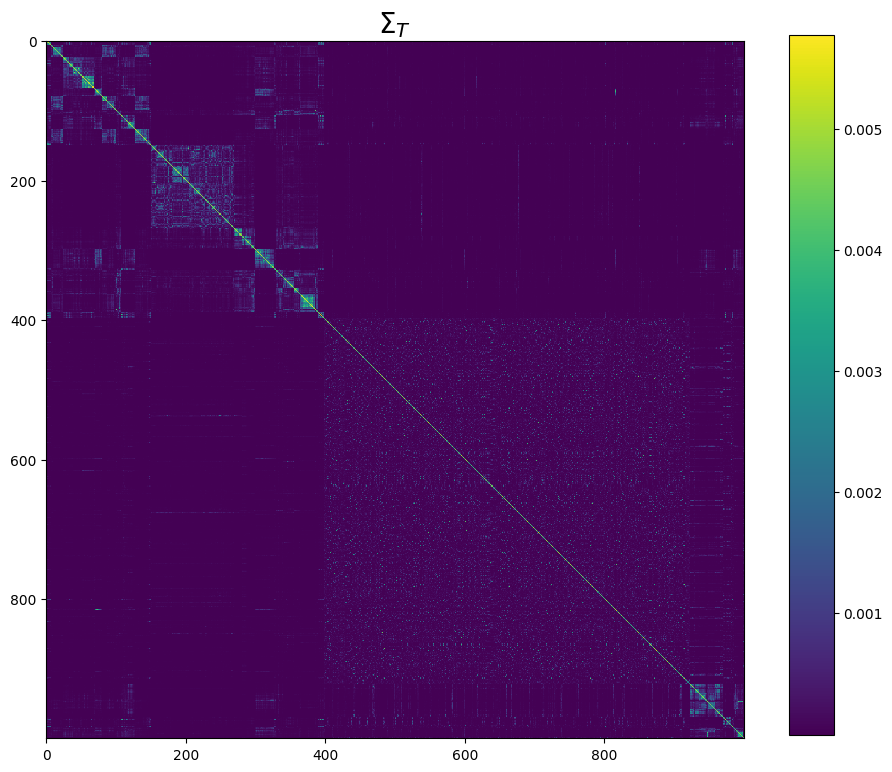

In [18]:
plot_covariance(SigmaT, r'$\Sigma_T$', size=(9,10));

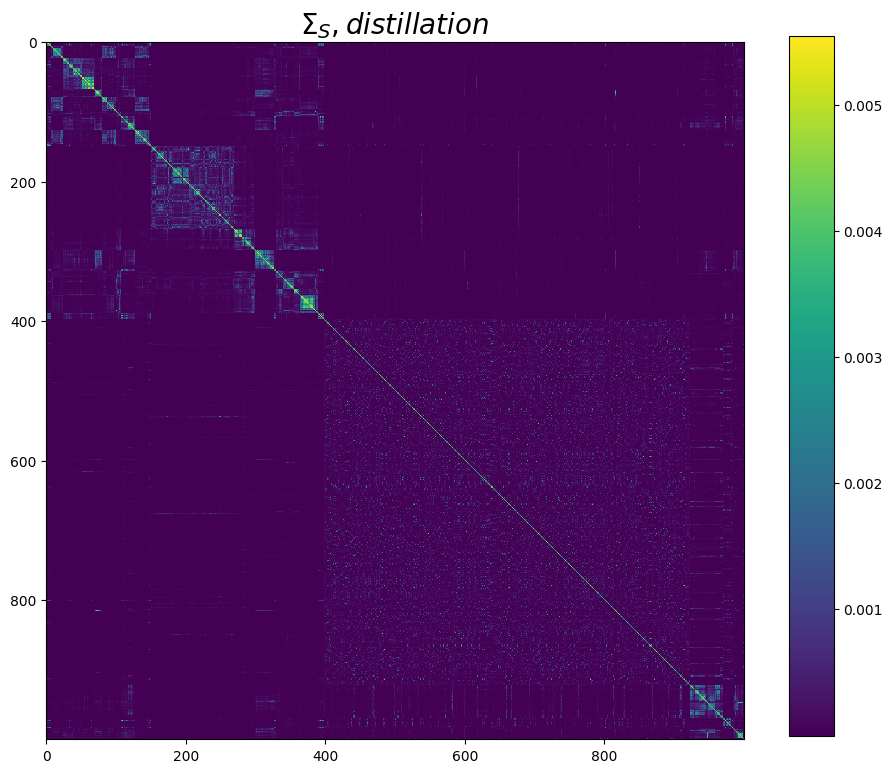

In [29]:
plot_covariance(SigmaS, r'$\Sigma_S, distillation$', size=(9,10));

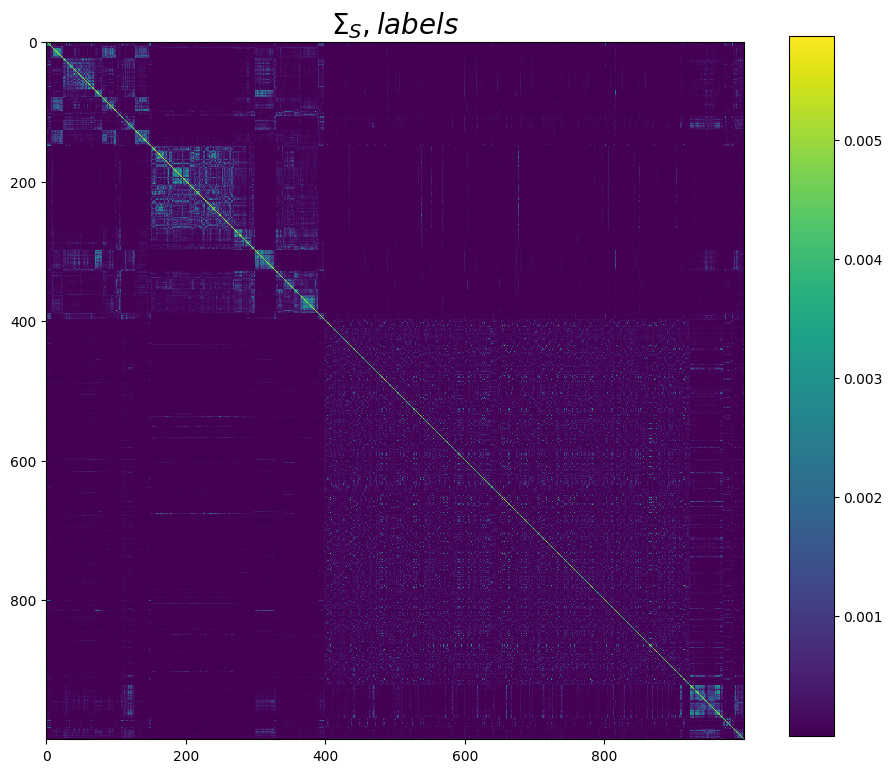

In [32]:
plot_covariance(SigmaS_2, r'$\Sigma_S, labels$', size=(9,10));

### CIFAR 100

In [6]:

C100_train, C100_val = load_dataset('cifar100', augment=False)
all_data = ConcatDataset([C100_train, C100_val])
loader = DataLoader(all_data, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

In [8]:
CIFAR100sparse2coarse(9)

3

In [7]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "chkpts" + "/" + "cifar100" + "/" + "resnet18/"
    if best: filepath = path + 'model_best.ckpt'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          return checkpoint
    return None 

In [10]:
# initialising the model
teacher = resnet18(num_classes=100)
#teacher = make_cnn(c=150, num_classes=100, use_batch_norm=True)
CHKPT_NAME = 'resnet18-teacher.ckpt'
#CHKPT_NAME = 'convnet150-teacher.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME) 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-teacher.ckpt


In [11]:

SEEDS = [11, 13, 21, 33, 55]

In [34]:
SigmaT = compute_covariance(loader, teacher, num_classes=100, device=device, temperature=10)

/tmp/ipykernel_74854/3179224318.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs.view(-1,num_classes,1)/T)
[ 11-30 | 13:45 ] Task Computing covariance | epoch -1: |██████████████████████████████████████████████████| 320.99 ep/h | loss: 0.9978678 ||

In [12]:
def superclass_order():
    counters = [0]*20
    order = [0]*100
    for i in range(100):
        supcl = CIFAR100sparse2coarse(i)
        new_index = counters[supcl] + supcl*5
        counters[supcl] +=1
        order[i] = new_index
    return order

sup_order = superclass_order()
sup_order

[20,
 5,
 70,
 40,
 0,
 30,
 35,
 36,
 90,
 15,
 16,
 71,
 45,
 91,
 37,
 55,
 17,
 46,
 38,
 56,
 31,
 57,
 25,
 50,
 39,
 32,
 65,
 75,
 18,
 76,
 1,
 58,
 6,
 51,
 60,
 72,
 80,
 47,
 59,
 26,
 27,
 95,
 41,
 42,
 77,
 66,
 73,
 85,
 92,
 52,
 81,
 21,
 86,
 22,
 10,
 2,
 87,
 23,
 93,
 88,
 53,
 19,
 11,
 61,
 62,
 82,
 63,
 7,
 48,
 96,
 12,
 54,
 3,
 8,
 83,
 64,
 49,
 67,
 78,
 68,
 84,
 97,
 13,
 24,
 33,
 98,
 28,
 29,
 43,
 99,
 94,
 9,
 14,
 79,
 34,
 4,
 89,
 44,
 74,
 69]

In [22]:
len(np.unique(sup_order)) # double-check that we did a permutation

100

In [13]:
def order_covariance_supclass(Sigma):
    Sigma_ordered = deepcopy(Sigma)
    for row in range(100):
        for col in range(100):
            Sigma_ordered[sup_order[row], sup_order[col]] = Sigma[row,col]
    return Sigma_ordered

In [35]:
SigmaT_ordered = order_covariance_supclass(SigmaT)

In [36]:
student = resnet18(num_classes=100)
seed = SEEDS[4]
buffer_size = 24000
alpha = 1.0
STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


In [37]:
SigmaS1 = compute_covariance(loader, student, num_classes=100, device=device)

/tmp/ipykernel_2587112/4231022350.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs.view(-1,num_classes,1))
[ 11-27 | 10:00 ] Task Computing covariance | epoch -1: |██████████████████████████████████████████████████| 959.23 ep/h | loss: 0.9978678 |||

In [38]:
SigmaS1_ordered = order_covariance_supclass(SigmaS1)

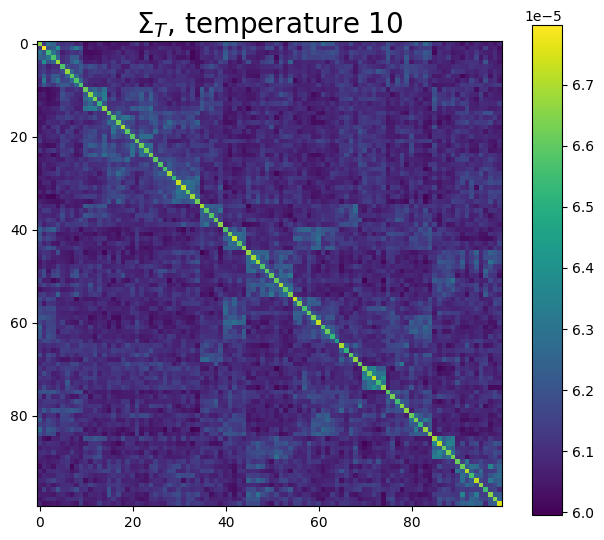

In [36]:
plot_covariance(SigmaT_ordered, r'$\Sigma_T$, temperature 10', size=(6,7));

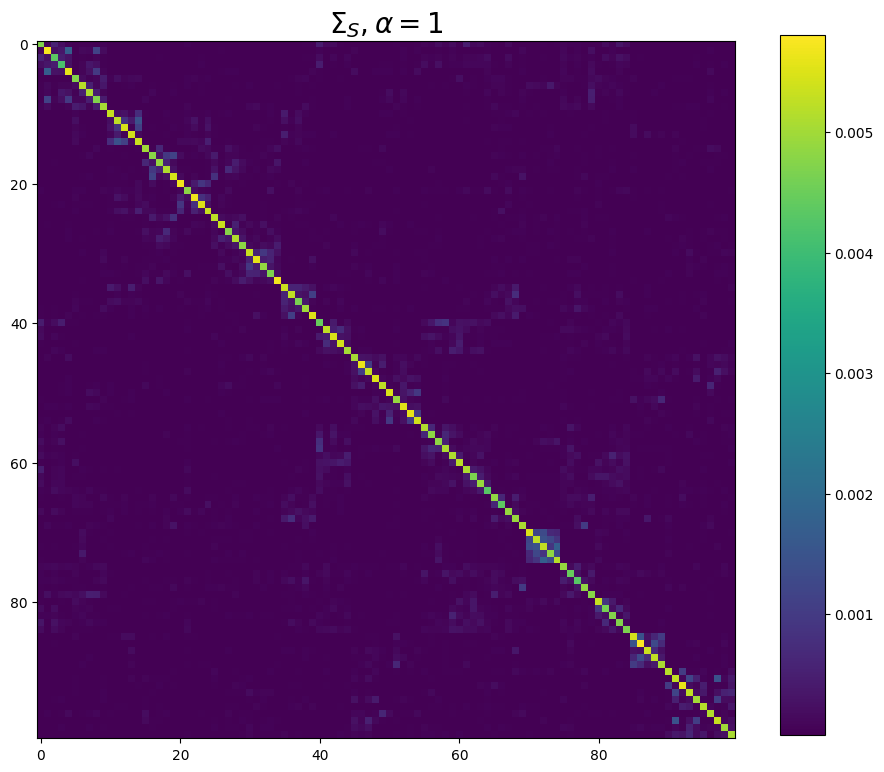

In [40]:
plot_covariance(SigmaS1_ordered, r'$\Sigma_S, \alpha=1$', size=(9,10));

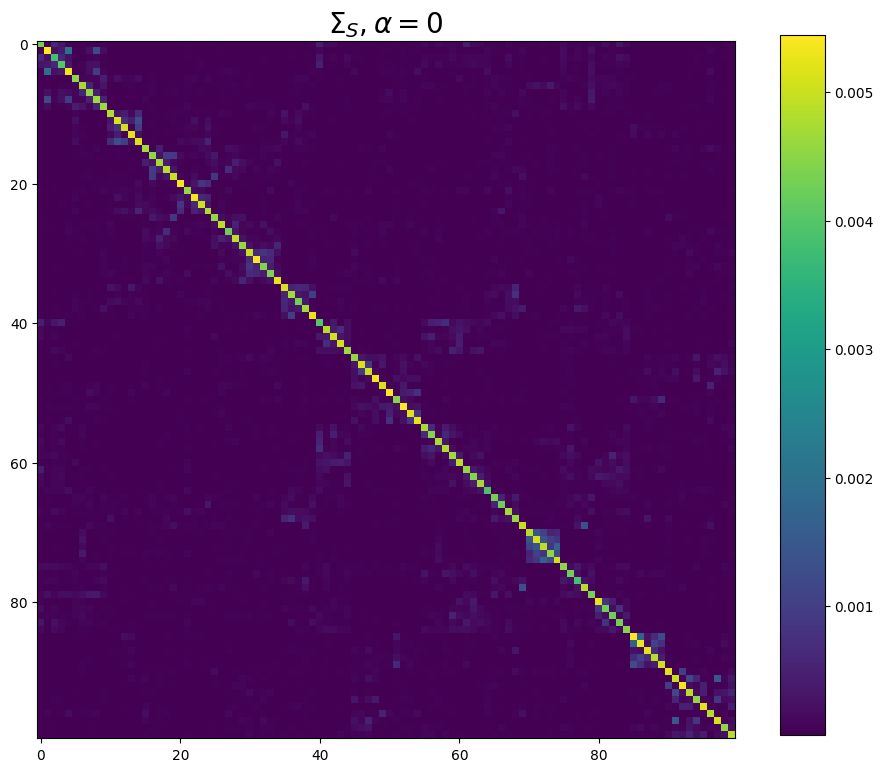

In [35]:
plot_covariance(SigmaS0_ordered, r'$\Sigma_S, \alpha = 0$', size=(9,10));

In [52]:
np.trace(np.matmul(SigmaT, SigmaS0))/(np.linalg.norm(SigmaT)*np.linalg.norm(SigmaS0))

0.9943273772362188

In [53]:
np.trace(np.matmul(SigmaT, SigmaS1))/(np.linalg.norm(SigmaT)*np.linalg.norm(SigmaS1))

0.9948549395554245

In [54]:
np.trace(np.matmul(SigmaS0, SigmaS1))/(np.linalg.norm(SigmaS0)*np.linalg.norm(SigmaS1))

0.998022803209832

In [ ]:
path=base_path() + "/results" + "/imagenet" + "/resnet50" + "/"
np.save(path + "SigmaY.npy", SigmaY)
np.save(path + "SigmaT.npy", SigmaT)